In [56]:
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
sys.path.append('/eos/project/l/liu/Toolbox/')
from myToolbox import *
from scipy.signal import savgol_filter
import gzip
#from uncertainties import ufloat

In [57]:
#myFiles=glob.glob('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018*.mat')
myFiles=glob.glob('/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018*.mat')
#print myFiles

In [58]:
myFiles

['/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.22.54.574.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.23.37.474.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.24.20.661.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.25.03.857.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.25.47.070.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.26.30.282.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.27.13.475.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.28.00.262.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.28.55.465.mat',
 '/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_naturalChroma_tunescan/2018.10.24.19.29.50.657.mat',
 '/eos/user/h/harafi

In [59]:
def fromMatlabToDataFrame(listing, listOfVariableToAdd, verbose=False, matlabFullInfo=False):
    listOfVariableToAdd=list(set(listOfVariableToAdd))
    myDataFrame=pnd.DataFrame({})
    cycleStamp=[]
    cycleStampHuman=[]
    PLS_matlab=[]
    matlabObject=[]
    matlabFilePath=[]
    for j in listOfVariableToAdd:
        exec(j.replace('.','_')+'=[]')
    for i in listing:
        if verbose:
            print(i)
        data=myToolbox.japcMatlabImport(i);
        if matlabFullInfo:
            matlabObject.append(data)
        #to correct
        localCycleStamp=np.nanmax(data.headerCycleStamps);
        deltaLocal_UTC=datetime.datetime.fromtimestamp(localCycleStamp/1e9)-datetime.datetime.utcfromtimestamp(localCycleStamp/1e9)
        utcCycleStamp=localCycleStamp+deltaLocal_UTC.total_seconds()*1e9
        cycleStamp.append(utcCycleStamp)
        aux=myToolbox.unixtime2datetimeVectorize(np.nanmax(data.headerCycleStamps)/1e9)
        cycleStampHuman.append(aux.tolist())
        PLS_matlab.append(data.cycleName)
        matlabFilePath.append(os.path.abspath(i))
        for j in listOfVariableToAdd:
            if hasattr(data,j.split('.')[0]):
                exec(j.replace('.','_') + '.append(data.' + j + ')')
            else:
                exec(j.replace('.','_') + '.append(np.nan)')
    myDataFrame['cycleStamp']=pnd.Series(cycleStamp,cycleStampHuman)
    myDataFrame['matlabPLS']=pnd.Series(PLS_matlab,cycleStampHuman)
    myDataFrame['matlabFilePath']=pnd.Series(matlabFilePath,cycleStampHuman)
    if matlabFullInfo:
        myDataFrame['matlabFullInfo']=pnd.Series(matlabObject,cycleStampHuman)
    for j in listOfVariableToAdd:
        exec('myDataFrame[\'' + j + '\']=pnd.Series(' +j.replace('.','_')+ ',cycleStampHuman)')    #myDataFrame=pnd.DataFrame({j:aux,
    return myDataFrame

def intensity_df(ndf,start=85,end=1185):
    df=ndf.copy()
    def losses(a):
        try:
            b=(a[start]-a[end])/a[start]*100 
        except:
            b=np.nan
        return b
    def ratio(a):
        try:
            c=a[end]/a[start]
        except:
            c=np.nan
        return c
    def max_intensity(a):
        try:
            d=np.max(a)
        except:
            d=np.nan
        return d*1E10
    df['intensity']=df['PR_BCT_ST.Samples.value.samples'].apply(max_intensity)
    df['losses']=df['PR_BCT_ST.Samples.value.samples'].apply(losses)
    df['ratio']=df['PR_BCT_ST.Samples.value.samples'].apply(ratio)
    return df

def read_data(year=2018,month=9,date=5,hour=10,minutes=0,span=5,user='CPS%MD1',WS='64.V'):
    t1=datetime.datetime(year,month,date,hour,minutes)
    t2=t1+datetime.timedelta(hours=span)
    CALS=['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS),  'PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS),  'PR.BWS.{}_ROT:ACQ_DELAY'.format(WS), 'PR.BCT.LT:SAMPLES']
    df=myToolbox.fromTimberToDataFrame(CALS,t1,t2,fundamental=user)
    return  df

def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def gaussian_5_parameters(x, c, m, A, mu, sig):
    """gaussian_5_parameter(x, c, m, A, mu, sig)"""
    return c+m*x+A/np.sqrt(2*np.pi)/sig*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def makeGaussianFit_5_parameters(X,Y,for_df=False,window=50):
    try:      
        #i = np.where( (X>min(X)+10) & (X<max(X)-10) )
        i = np.where( (X>-40) & (X<40) )
        #i = np.where( (Y>1.01*min(Y)) & (Y<0.99*max(Y)) )
        X = X[i]
        Y = Y[i]
        indx_max = np.argmax(Y)
        mu0 = X[indx_max]
        window = window
        x_tmp = X[indx_max-window:indx_max+window]
        y_tmp = Y[indx_max-window:indx_max+window]
        offs0 = min(y_tmp)
        ampl = max(y_tmp)-offs0
        x1 = x_tmp[np.searchsorted(y_tmp[:window], offs0+ampl/2)]
        x2 = x_tmp[np.searchsorted(-y_tmp[window:], -offs0+ampl/2)]
        FWHM = x2-x1
        sigma0 = np.abs(2*FWHM/2.355)
        ampl *= np.sqrt(2*np.pi)*sigma0
        slope = 0
        popt,pcov = curve_fit(gaussian_5_parameters,X,Y,p0=[offs0,slope,ampl,mu0,sigma0])
        if for_df:
            return popt[2], popt[0], popt[3], popt[4]
        else:    
            return popt#{'c': popt[0], 'm': popt[1],'A': popt[2], 'mu': popt[3], 'sig': popt[4], 'pcov': pcov, 'p': popt}
    except:
        if for_df:
            return np.nan,np.nan, np.nan, np.nan
        else:
            return [np.nan,np.nan, np.nan, np.nan,np.nan]#{k: np.nan for k in ['c', 'm','A', 'mu', 'sig', 'pcov', 'p']}def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def filtered(a):
    try:
        b=(scipy.signal.savgol_filter(a,15,1))
    except:
        b=np.nan
    return b

def profiles(ndf,WS='64.V',myFiles=None):
    df=ndf.copy()
    # play with these limits
    #x=np.linspace(-40,40,1000)
    x=np.linspace(-25,25,1000)
    a=df.columns
    if 'profile '+WS[-1] not in a:
        df['profile '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS)].apply(filtered)
        df['position '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS)].values/1000.
    if 'sig '+WS[-1] not in a:
        df['sig '+WS[-1]]=np.nan
        df['mu '+WS[-1]]=np.nan
        df['c '+WS[-1]]=np.nan
        df['A '+WS[-1]]=np.nan

    span=span_range(df,myFiles=myFiles)
    if np.isnan(df['sig '+WS[-1]].iloc[span]).all():
        for i in span:
            df['A '+WS[-1]].iloc[i],df['c '+WS[-1]].iloc[i],df['mu '+WS[-1]].iloc[i],df['sig '+WS[-1]].iloc[i]=makeGaussianFit_5_parameters(df['position '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i],for_df=True)
            try:
                yz=scipy.interpolate.interp1d(df['position '+WS[-1]].iloc[i]-df['mu '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i]-df['c '+WS[-1]].iloc[i])(x)
                if np.isnan(yz[0]):
                    yz=np.nan
            except:
                yz = np.nan
            df['profile '+WS[-1]].iloc[i]=yz
            df['position '+WS[-1]].iloc[i]=x
    return df

def second_moment_2(values, weights, sig, n_sigmas=6.):
    a=np.where((values<n_sigmas*sig) & (values>-n_sigmas*sig))[0]
    values=values[a]
    weights=weights[a]    
    weighted_average = np.average(values, weights=weights)
    second_moment = np.sqrt(np.average((values-weighted_average)**2, weights=weights))
    return (second_moment)

def PS_WSoptics_old(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_new.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    startindx = {'64': 0, '65': 961, '68': 1922, '85':2883}
    stopindx = {'64': 960, '65': 1921, '68': 2882, '85':3843}
    bx = betx[startindx[WS]:stopindx[WS]]
    by = bety[startindx[WS]:stopindx[WS]]
    Dx = dx[startindx[WS]:stopindx[WS]]
    qh1=qh[startindx[WS]:stopindx[WS]]
    qv1=qv[startindx[WS]:stopindx[WS]]
    betax = scipy.interpolate.interp2d(qh1,qv1,bx)
    betay = scipy.interpolate.interp2d(qh1,qv1,by)
    dispx = scipy.interpolate.interp2d(qh1,qv1,Dx)
    result ={'Beta_x':betax(tunex,tuney), 'Beta_y':betay(tunex,tuney),'D_x': dispx(tunex,tuney)}
    #print 'PS_Woptics: Qx, Qy, Beta_x, Beta_y, D_x'
    #print tunex, '\t', tuney, '\t', betax(tunex,tuney), '\t', betay(tunex, tuney), '\t', dispx(tunex, tuney)
    return result


def PS_WSoptics(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_6p01_6p35.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    file_iter = 4586
    startindx = {'64': 0, '65': (file_iter+1), '68': (2*file_iter)+1, '85':(3*file_iter)+1}
    stopindx = {'64': file_iter, '65': (2*file_iter), '68': (3*file_iter), '85':(4*file_iter)}
   
    def five_round(x, base=5):
        return int(base * round(float(x)/base))
    
    # Translate tunex, tuney, WS into a line number using the sequence of saved tunes
    # Need to handle the 0.005 step now (previously rounded to nearest 'integer')
    # File iterates from Qx,y = 4.01 - 4.35 in steps of 0.005 = 68 steps
    f_steps = 68
    f_xstart = 0.01
    f_ystart = 0.01
    line_number = (int(five_round((tunex-f_xstart)*100)*f_steps)) + (int(five_round((tuney-f_ystart)*100))) + startindx[WS]
    
    
    # Translate tunex, tuney, WS into a line number using the sequence of saved tunes
   # line_number = (int(round((tunex-.05)*100)*31)) + (int(round((tuney-.05)*100))) + startindx[WS]
    
    result ={'Beta_x':betx[line_number], 'Beta_y':bety[line_number],'D_x': dx[line_number]}
    #print 'PS_Woptics: Line_no, Tunex, Tuney, Qx, Qy, Beta_x, Beta_y, D_x'
    #print line_number, '\t',tunex, '\t', tuney, '\t', qh[line_number], '\t', qv[line_number], '\t', betx[line_number], '\t', bety[line_number], '\t', dx[line_number]
    return result

def twiss(ndf,WS='65.H',myFiles=None):
    df=ndf.copy()
    a=df.columns
    if 'betx' not in a:
        df['betx']=np.nan
    if 'bety' not in a:
         df['bety']=np.nan
    if 'dx' not in a:
         df['dx']=np.nan
    span=span_range(df,myFiles=myFiles)
    for i in span:
            df.loc[df.index[i],'betx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_x']
            df.loc[df.index[i],'dx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['D_x']
            df.loc[df.index[i],'bety']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_y']
    return df

def emittance_df(ndf,WS='65.H',myFiles=None,beta=0.91444281513833,gamma=2.4708737618826,dp=1e-3):
    df=ndf.copy()
    a=df.columns
    if 'emittance V' not in a:
        df['emittance V']=np.nan
    if 'emittance H' not in a:
        df['emittance H']=np.nan
    if 'sig V' not in a:
        df=profiles(df,WS=WS)
    if 'sig H' not in a:
        df=profiles(df,WS=WS)
    span=span_range(df,myFiles=myFiles)
    if WS[-1]=='V':
        if 'bety' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance V']=beta*gamma*(df['sig V'].iloc[i]**2)/df['bety'].iloc[i]
    else:
        if 'betx' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance H']=beta*gamma*(df['sig H'].iloc[i]**2-(df['dx'].iloc[i]*1000)**2*dp**2)/df['betx'].iloc[i]
    return df

In [60]:
#myDataStruct = scipy.io.loadmat('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018.09.05.13.47.50.436.mat',squeeze_me=True, struct_as_record=False)

#myDataStruct = scipy.io.loadmat('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018.09.05.13.47.50.436.mat',squeeze_me=True)

# Make a master dataframe? 

In [61]:
df_test = fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp','PR_BCT_ST.Samples.value.samples','PR_BCT_ST.Samples.cycleStamp'])

In [62]:
df_test['PR_BCT_ST.Samples.cycleStamp']=df_test['PR_BCT_ST.Samples.cycleStamp']/1e9
df_test['PR_BQS72.SamplerAcquisition.cycleStamp']=df_test['PR_BQS72.SamplerAcquisition.cycleStamp']/1e9

In [63]:
# Check cyclestamp differences

# Iterate over each row in the dataframe
differences = []
for index, row in df_test.iterrows():
    difference = (row['PR_BCT_ST.Samples.cycleStamp'] - row['PR_BQS72.SamplerAcquisition.cycleStamp'])/row['PR_BCT_ST.Samples.cycleStamp']
    differences.append(difference)
    
print 'Difference between BCT and BQS73 cycle times (percentage) \n Mean:', np.mean(differences),' Min:',np.min(differences),' Max:', np.max(differences)

# Iterate over each row in the dataframe
differences = []
for index, row in df_test.iterrows():
    difference = (row['cycleStamp'] - (row['PR_BCT_ST.Samples.cycleStamp']*1E9))/row['cycleStamp']
    differences.append(difference)
    
print '\nDifference between BCT and cyclestamp cycle times (percentage) \n Mean:', np.mean(differences),' Min:',np.min(differences),' Max:', np.max(differences)

Difference between BCT and BQS73 cycle times (percentage) 
 Mean: -5.183850673126798e-11  Min: -2.804463214161598e-08  Max: 0.0

Difference between BCT and cyclestamp cycle times (percentage) 
 Mean: 4.676420925643351e-06  Min: 4.674019584953393e-06  Max: 4.725496627040812e-06


In [64]:
df_test

,cycleStamp,matlabPLS,matlabFilePath,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.cycleStamp,PR_BCT_ST.Samples.cycleStamp,PR_BCT_ST.Samples.value.samples,PR_BQS72.SamplerAcquisition.value.estimatedTuneH
2018-10-24 19:22:51.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04737863670211139, nan, 0.04094432311483449...",1.540402e+09,1.540402e+09,"[-0.15825, -0.14783000000000002, -0.1502800000...","[nan, 0.3105663235759711, nan, 0.3104163192336..."
2018-10-24 19:22:07.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.043652211519404585, nan, 0.0470124290875650...",1.540402e+09,1.540402e+09,"[-0.15825, -0.14783000000000002, -0.1502800000...","[nan, 0.33018601371375267, nan, 0.342708177016..."
2018-10-24 19:22:51.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04737863670211139, nan, 0.04094432311483449...",1.540402e+09,1.540402e+09,"[-0.17481000000000002, -0.16316, -0.1508900000...","[nan, 0.3105663235759711, nan, 0.3104163192336..."
2018-10-24 19:23:34.300,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04044030959984465, nan, 0.04996536849943547...",1.540402e+09,1.540402e+09,"[-0.24229000000000003, -0.22634, -0.2036400000...","[nan, 0.31042593103560623, nan, 0.310389703961..."
2018-10-24 19:24:17.500,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04664160067391109, nan, 0.0648878841514922,...",1.540402e+09,1.540402e+09,"[-0.23002000000000003, -0.2245, -0.21591000000...","[nan, 0.2968728698606682, nan, 0.3313028572717..."
2018-10-24 19:25:00.700,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.0571496105118786, nan, 0.05288216912337934,...",1.540402e+09,1.540402e+09,"[-0.17236, -0.16071000000000002, -0.1508900000...","[nan, 0.34399753790672566, nan, 0.328322764166..."
2018-10-24 19:25:43.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.042346359551280285, nan, 0.0398693342260222...",1.540402e+09,1.540402e+09,"[-0.20487000000000002, -0.18463000000000002, -...","[nan, 0.30996969410456293, nan, 0.310411241749..."
2018-10-24 19:26:27.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04256077370422034, nan, 0.04488534621815969...",1.540402e+09,1.540402e+09,"[-0.24535, -0.23002000000000003, -0.21898, -0....","[nan, 0.31036935206023686, nan, 0.310342876369..."
2018-10-24 19:27:10.300,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.05524225151149971, nan, 0.05274219459394844...",1.540402e+09,1.540402e+09,"[-0.15580000000000002, -0.15089000000000002, -...","[nan, 0.3102750899842476, nan, 0.3101798589894..."
2018-10-24 19:27:57.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.03976755758964533, nan, 0.05044438612629375...",1.540402e+09,1.540402e+09,"[-0.20487000000000002, -0.19260000000000002, -...","[nan, 0.3101273614508164, nan, 0.3100795562762..."


In [65]:
df_bct = fromMatlabToDataFrame(myFiles,['PR_BCT_ST.Samples.value.samples','PR_BCT_ST.Samples.cycleStamp'])
df_bqs72 = fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp'])

In [66]:
df_mergetest = pnd.merge(df_bct, df_bqs72, left_on = 'PR_BCT_ST.Samples.cycleStamp',  right_on = 'PR_BQS72.SamplerAcquisition.cycleStamp')
#df_mergetest

In [67]:
df_mergetest['PR_BQS72.SamplerAcquisition.cycleStamp']=df_mergetest['PR_BQS72.SamplerAcquisition.cycleStamp']/1e9
df_mergetest = df_mergetest.rename(index=str, columns={"PR_BQS72.SamplerAcquisition.cycleStamp" : "cycleStamp", })
df_mergetest['PR_BQS72.SamplerAcquisition.cycleStamp']=df_mergetest['cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_mergetest = df_mergetest.set_index(['cycleStamp'])
df_mergetest = df_mergetest.drop(labels='matlabFilePath_x',axis='columns')
df_mergetest = df_mergetest.drop(labels='matlabFilePath_y',axis='columns')
df_mergetest = df_mergetest.drop(labels='cycleStamp_x',axis='columns')
df_mergetest = df_mergetest.drop(labels='cycleStamp_y',axis='columns')
df_mergetest = df_mergetest.drop(labels='matlabPLS_y',axis='columns')
df_mergetest = df_mergetest.drop(labels='matlabPLS_x',axis='columns')
df_mergetest = df_mergetest.drop(labels='PR_BCT_ST.Samples.cycleStamp',axis='columns')

In [68]:
df_mergetest

,PR_BCT_ST.Samples.value.samples,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,PR_BQS72.SamplerAcquisition.cycleStamp
cycleStamp,,,,
1.540402e+09,"[-0.15825, -0.14783000000000002, -0.1502800000...","[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",2018-10-24 19:22:07.900
1.540402e+09,"[-0.15825, -0.14783000000000002, -0.1502800000...","[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",2018-10-24 19:22:07.900
1.540402e+09,"[-0.17481000000000002, -0.16316, -0.1508900000...","[0.04737863670211139, nan, 0.04094432311483449...","[nan, 0.3105663235759711, nan, 0.3104163192336...",2018-10-24 19:22:51.100
1.540402e+09,"[-0.17481000000000002, -0.16316, -0.1508900000...","[0.04737863670211139, nan, 0.04094432311483449...","[nan, 0.3105663235759711, nan, 0.3104163192336...",2018-10-24 19:22:51.100
1.540402e+09,"[-0.24229000000000003, -0.22634, -0.2036400000...","[0.04044030959984465, nan, 0.04996536849943547...","[nan, 0.31042593103560623, nan, 0.310389703961...",2018-10-24 19:23:34.300
1.540402e+09,"[-0.23002000000000003, -0.2245, -0.21591000000...","[0.04664160067391109, nan, 0.0648878841514922,...","[nan, 0.2968728698606682, nan, 0.3313028572717...",2018-10-24 19:24:17.500
1.540402e+09,"[-0.17236, -0.16071000000000002, -0.1508900000...","[0.0571496105118786, nan, 0.05288216912337934,...","[nan, 0.34399753790672566, nan, 0.328322764166...",2018-10-24 19:25:00.700
1.540402e+09,"[-0.20487000000000002, -0.18463000000000002, -...","[0.042346359551280285, nan, 0.0398693342260222...","[nan, 0.30996969410456293, nan, 0.310411241749...",2018-10-24 19:25:43.900
1.540402e+09,"[-0.24535, -0.23002000000000003, -0.21898, -0....","[0.04256077370422034, nan, 0.04488534621815969...","[nan, 0.31036935206023686, nan, 0.310342876369...",2018-10-24 19:26:27.100


# Tune using master df

In [69]:
# properly handle the tune time

test = myToolbox.japcMatlabImport(myFiles[0])

# Start of timing
tune_start_time = (test.PR_BQS72.SamplerAcquisition.value.acqOffset + 170)
tune_period = test.PR_BQS72.SamplerAcquisition.value.acqPeriod
number_of_acq = test.PR_BQS72.SamplerAcquisition.value.nbOfMeas
interval = test.PR_BQS72.SamplerAcquisition.value.acqPeriod

#end of timing = number of ac * interval
tune_end_time = (number_of_acq * interval)
tune_time_steps = ((tune_end_time - tune_start_time) / number_of_acq)

sequence = np.linspace(tune_start_time, tune_end_time, number_of_acq)
#tune_end_time - tune_start_time
#tune_start_time
#tune_end_time
#np.size(sequence)

if np.size(sequence) != number_of_acq:
    print 'ERROR'
else:
    print 'Correct sequence created for tune x axis'

Correct sequence created for tune x axis


In [70]:
df_mergetest['Qx']=df_mergetest.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH'][20:280]),axis=1)
df_mergetest['Qy']=df_mergetest.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV'][20:280]),axis=1)

In [71]:
# Remove anomoalous cases
df_mergetest = df_mergetest.drop(df_mergetest[df_mergetest['Qx'] < .295].index )
df_mergetest = df_mergetest.dropna(axis=0,how='all',subset =['Qy'])
df_mergetest = df_mergetest.dropna(axis=0,how='all',subset =['Qx'])

In [72]:
df_mergetest

,PR_BCT_ST.Samples.value.samples,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,PR_BQS72.SamplerAcquisition.cycleStamp,Qx,Qy
cycleStamp,,,,,,
1.540402e+09,"[-0.15825, -0.14783000000000002, -0.1502800000...","[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",2018-10-24 19:22:07.900,0.319605,0.047874
1.540402e+09,"[-0.15825, -0.14783000000000002, -0.1502800000...","[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",2018-10-24 19:22:07.900,0.319605,0.047874
1.540402e+09,"[-0.17481000000000002, -0.16316, -0.1508900000...","[0.04737863670211139, nan, 0.04094432311483449...","[nan, 0.3105663235759711, nan, 0.3104163192336...",2018-10-24 19:22:51.100,0.317362,0.054175
1.540402e+09,"[-0.17481000000000002, -0.16316, -0.1508900000...","[0.04737863670211139, nan, 0.04094432311483449...","[nan, 0.3105663235759711, nan, 0.3104163192336...",2018-10-24 19:22:51.100,0.317362,0.054175
1.540402e+09,"[-0.24229000000000003, -0.22634, -0.2036400000...","[0.04044030959984465, nan, 0.04996536849943547...","[nan, 0.31042593103560623, nan, 0.310389703961...",2018-10-24 19:23:34.300,0.310337,0.047860
1.540402e+09,"[-0.23002000000000003, -0.2245, -0.21591000000...","[0.04664160067391109, nan, 0.0648878841514922,...","[nan, 0.2968728698606682, nan, 0.3313028572717...",2018-10-24 19:24:17.500,0.331443,0.045832
1.540402e+09,"[-0.17236, -0.16071000000000002, -0.1508900000...","[0.0571496105118786, nan, 0.05288216912337934,...","[nan, 0.34399753790672566, nan, 0.328322764166...",2018-10-24 19:25:00.700,0.321347,0.046086
1.540402e+09,"[-0.20487000000000002, -0.18463000000000002, -...","[0.042346359551280285, nan, 0.0398693342260222...","[nan, 0.30996969410456293, nan, 0.310411241749...",2018-10-24 19:25:43.900,0.312361,0.053079
1.540402e+09,"[-0.24535, -0.23002000000000003, -0.21898, -0....","[0.04256077370422034, nan, 0.04488534621815969...","[nan, 0.31036935206023686, nan, 0.310342876369...",2018-10-24 19:26:27.100,0.310312,0.043251


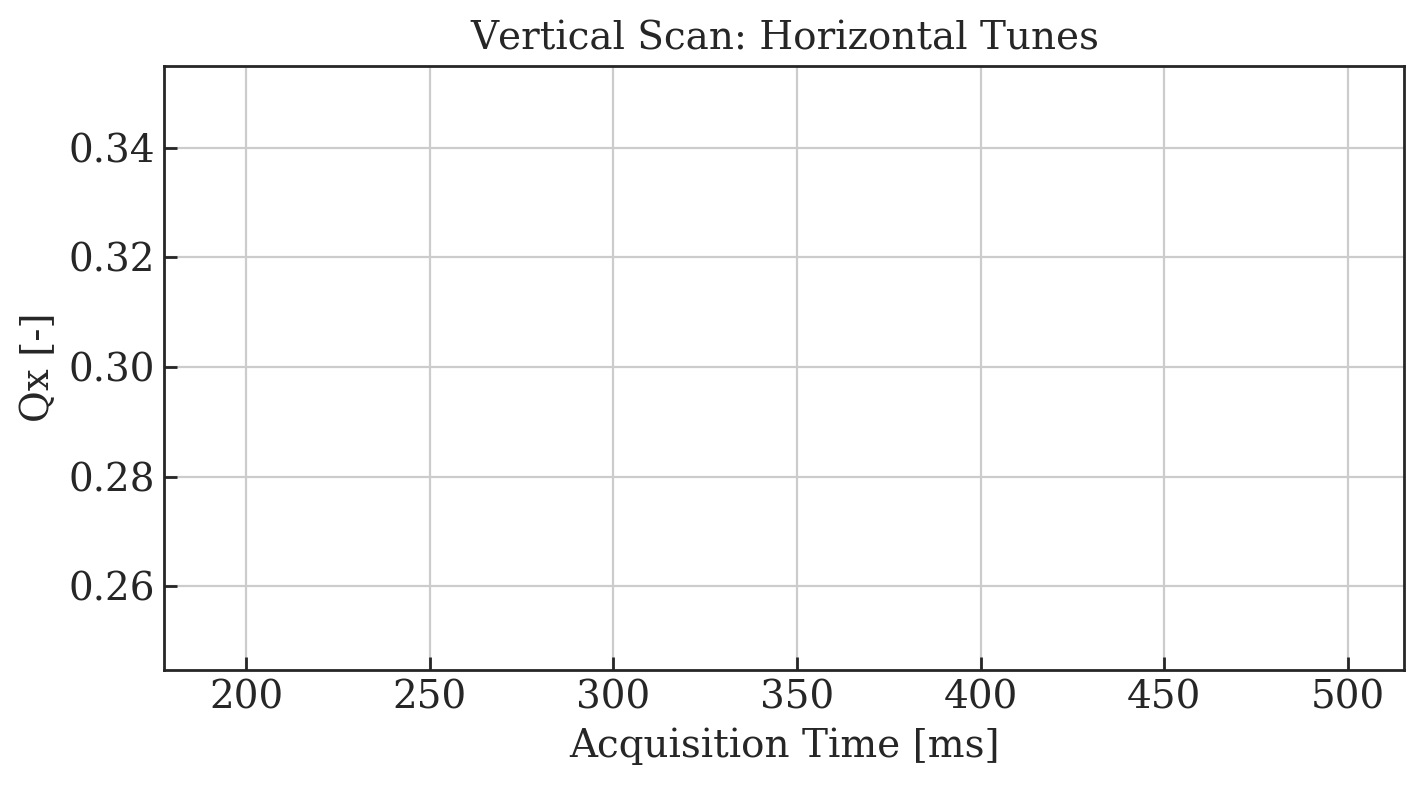

In [73]:
# Plot all Horizontal tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_mergetest.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.ylabel('Qx [-]')
plt.title('Vertical Scan: Horizontal Tunes')
plt.grid()
#plt.xlim(190, 200)
#plt.ylim(0.3, 0.31)
fig.savefig('MD4224_LowBrightness_Vertical_NaturalChroma_QX.png')

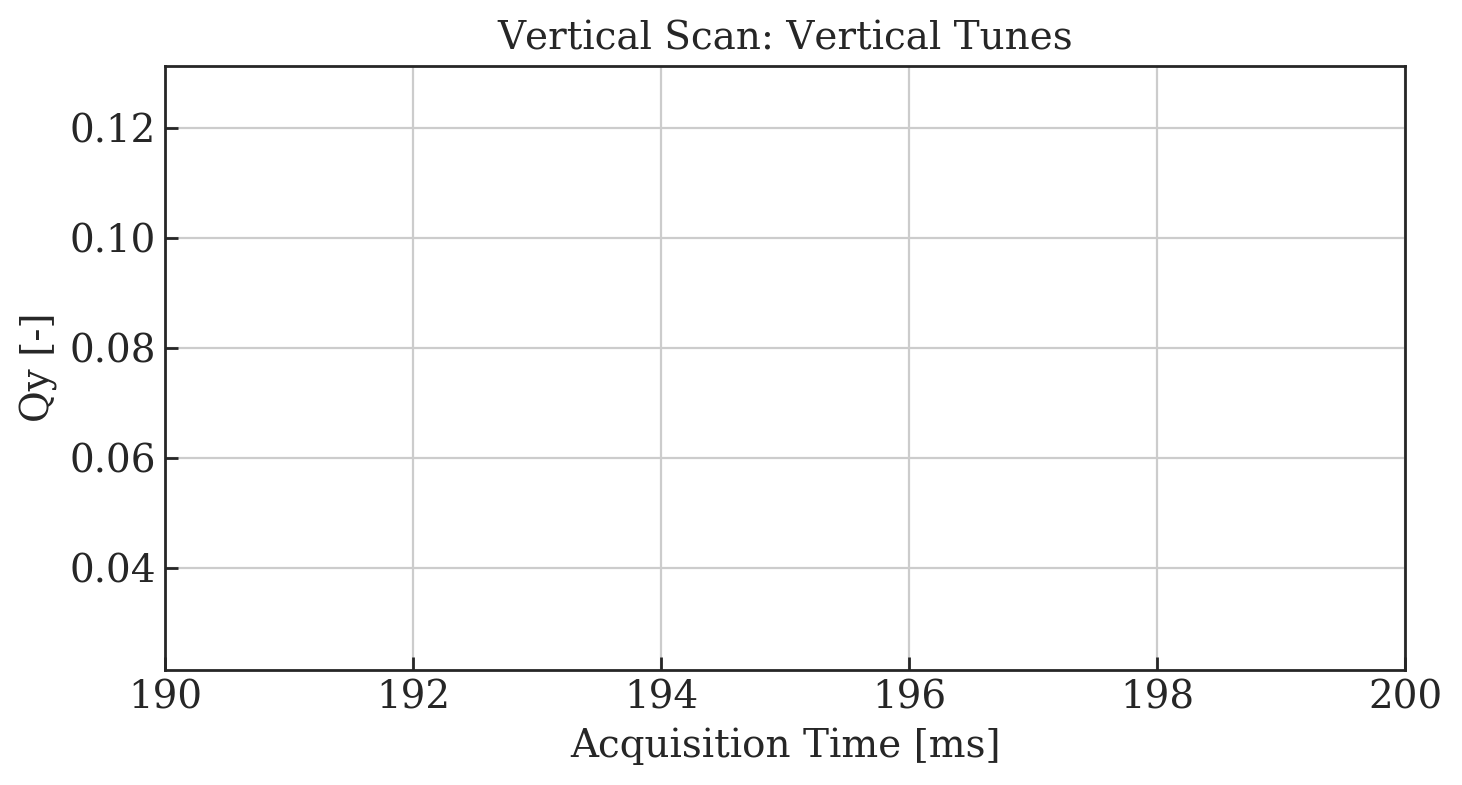

In [74]:
# Plot all Vertical tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_mergetest.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.xlim(190, 200)
#plt.ylim(0.005, 0.12)
plt.ylabel('Qy [-]')
plt.title('Vertical Scan: Vertical Tunes')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_NaturalChroma_QY.png')

In [75]:
df_mergetest = df_mergetest.drop(labels='PR_BQS72.SamplerAcquisition.value.estimatedTuneV',axis='columns')
df_mergetest = df_mergetest.drop(labels='PR_BQS72.SamplerAcquisition.value.estimatedTuneH',axis='columns')
#df_mergetest

# Intensity and Losses 

In [76]:
df_mergetest = df_mergetest.dropna(axis=0,how='all',subset =['Qy'])
df_mergetest = df_mergetest.dropna(axis=0,how='all',subset =['Qx'])
df_mergetest=intensity_df(df_mergetest,start=70,end=1185)

In [77]:
df_mergetest = df_mergetest.drop(labels='PR_BCT_ST.Samples.value.samples',axis='columns')
df_mergetest

,PR_BQS72.SamplerAcquisition.cycleStamp,Qx,Qy,intensity,losses,ratio
cycleStamp,,,,,,
1.540402e+09,2018-10-24 19:22:07.900,0.319605,0.047874,1.286260e+10,100.858302,-0.008583
1.540402e+09,2018-10-24 19:22:07.900,0.319605,0.047874,1.286260e+10,100.858302,-0.008583
1.540402e+09,2018-10-24 19:22:51.100,0.317362,0.054175,1.115130e+10,105.060397,-0.050604
1.540402e+09,2018-10-24 19:22:51.100,0.317362,0.054175,1.115130e+10,105.060397,-0.050604
1.540402e+09,2018-10-24 19:23:34.300,0.310337,0.047860,1.207750e+10,104.570482,-0.045705
1.540402e+09,2018-10-24 19:24:17.500,0.331443,0.045832,1.238420e+10,103.913050,-0.039131
1.540402e+09,2018-10-24 19:25:00.700,0.321347,0.046086,4.012140e+10,99.133710,0.008663
1.540402e+09,2018-10-24 19:25:43.900,0.312361,0.053079,4.086360e+10,99.582013,0.004180
1.540402e+09,2018-10-24 19:26:27.100,0.310312,0.043251,3.872900e+10,99.593009,0.004070


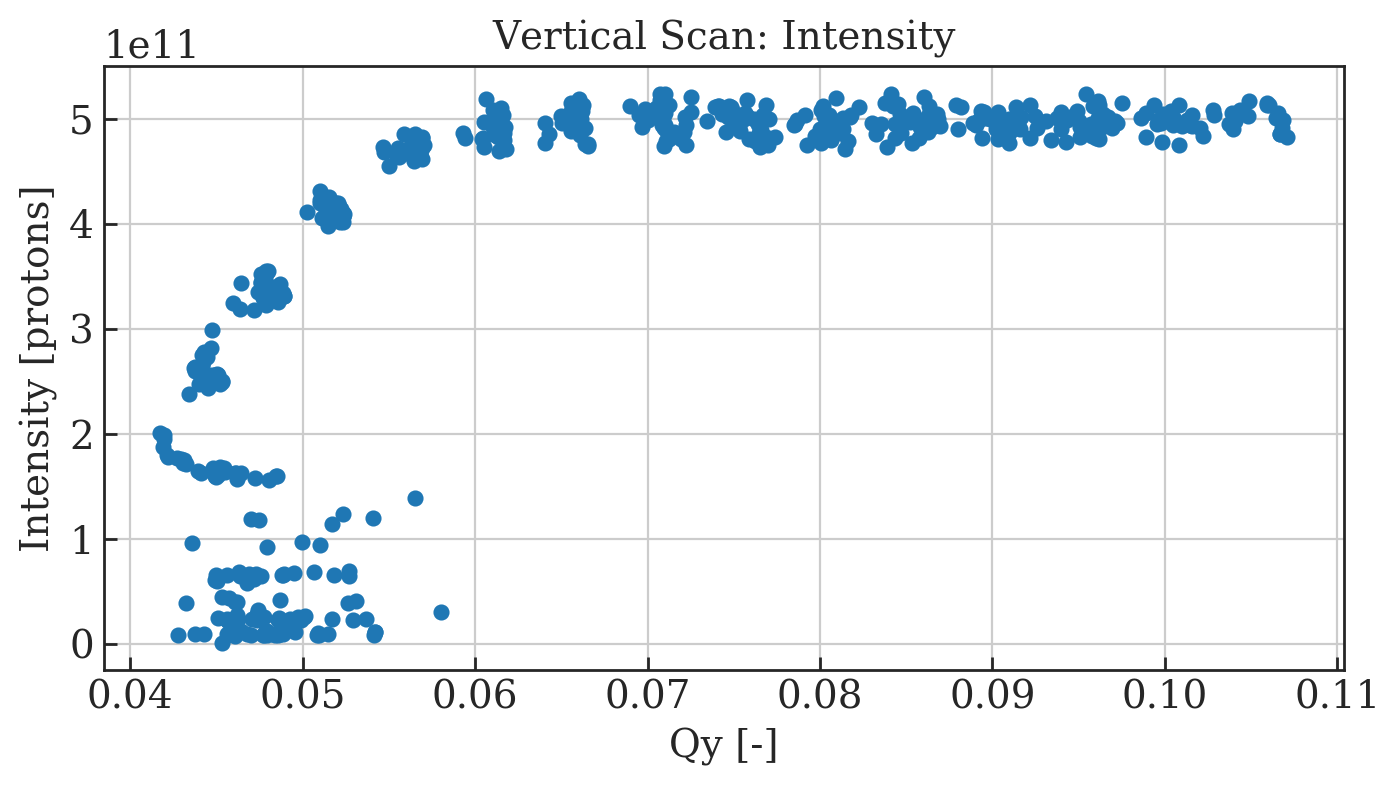

In [78]:
# Plot intensity as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qy'], df_mergetest['intensity'],'o')
plt.xlabel('Qy [-]')
plt.ylabel('Intensity [protons]')
plt.title('Vertical Scan: Intensity')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_NaturalChroma_Intensity_Qy.png')

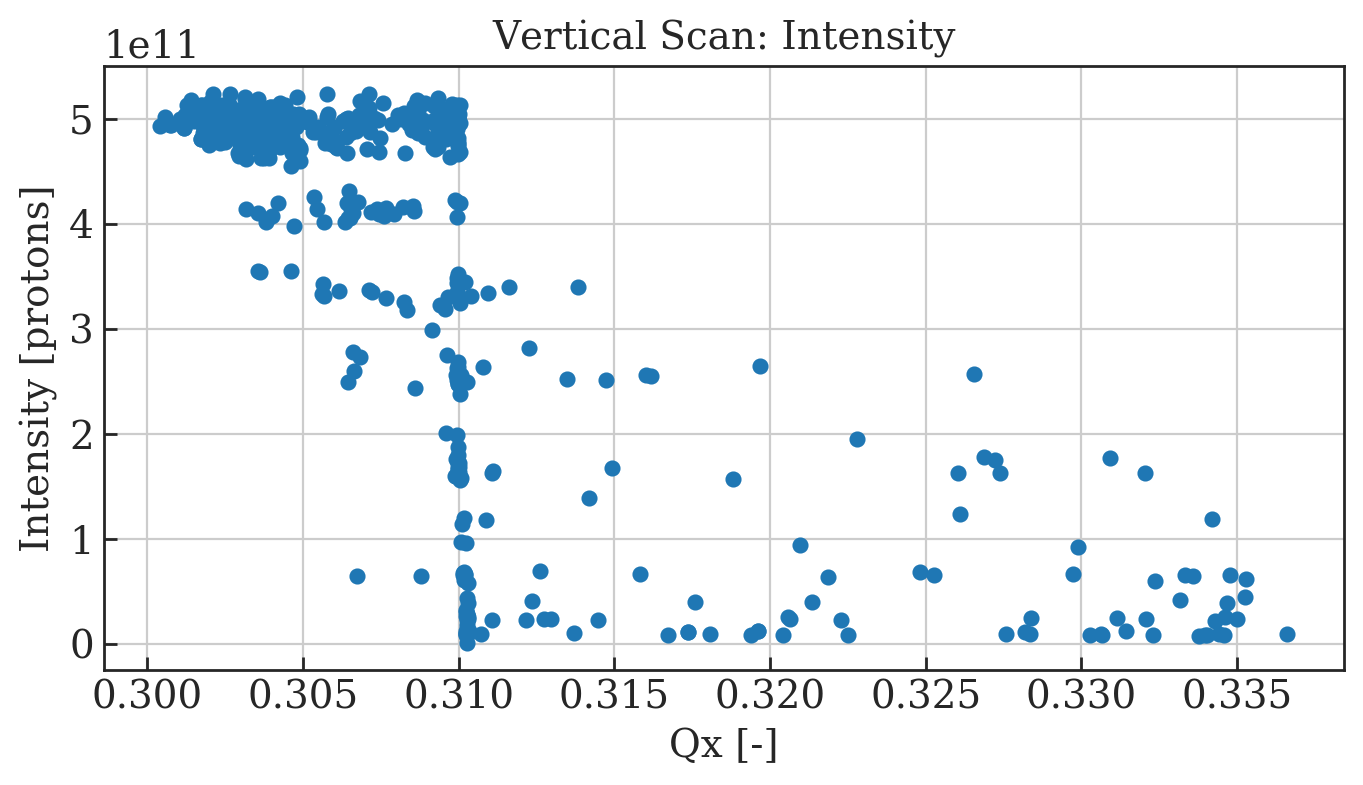

In [79]:
# Plot intensity as a function of Horizontal tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qx'], df_mergetest['intensity'],'o')
plt.xlabel('Qx [-]')
plt.ylabel('Intensity [protons]')
plt.title('Vertical Scan: Intensity')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_NaturalChroma_Intensity_Qx.png')

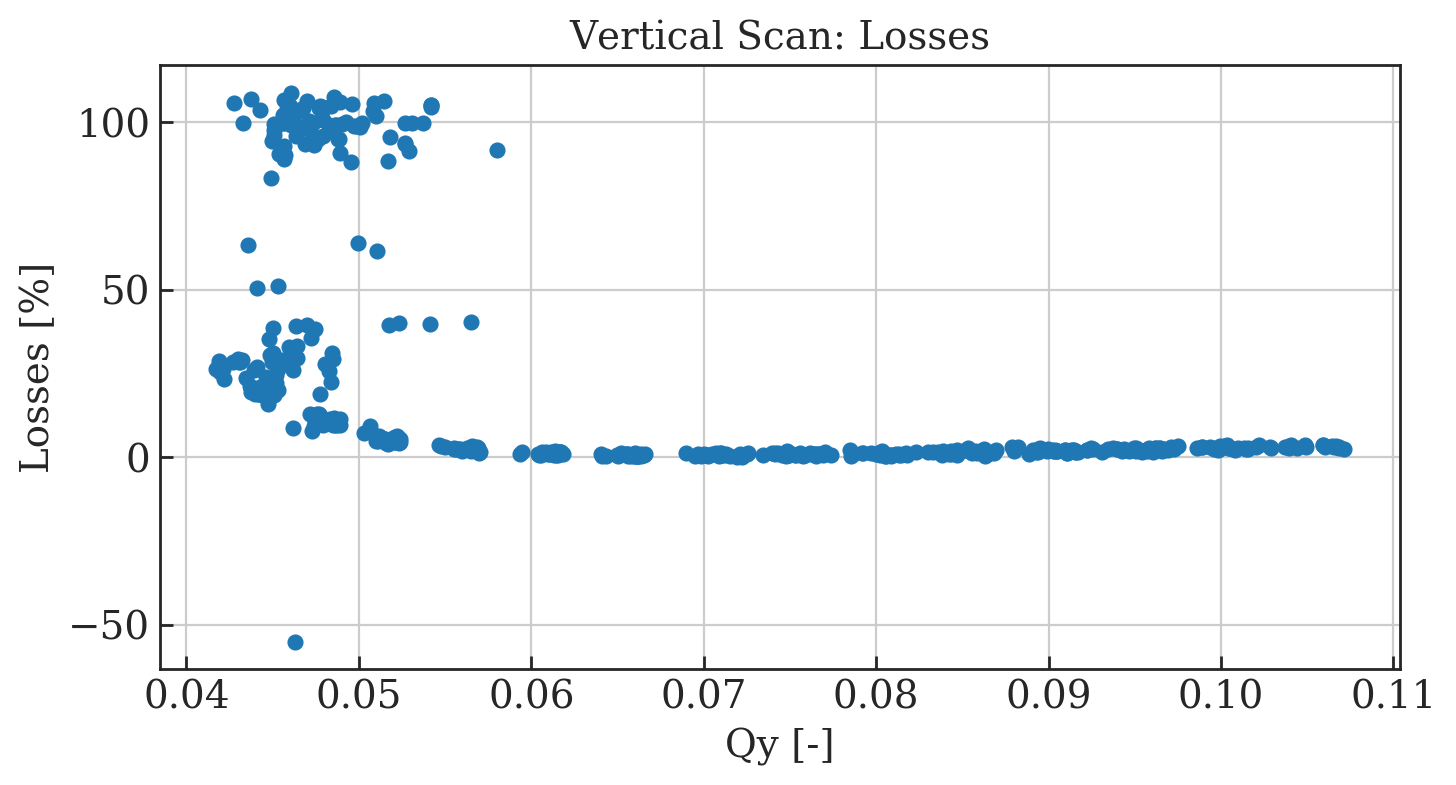

In [80]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qy'], df_mergetest['losses'],'o')
plt.xlabel('Qy [-]')
plt.ylabel('Losses [%]')
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_NaturalChroma_Losses_Qy.png')

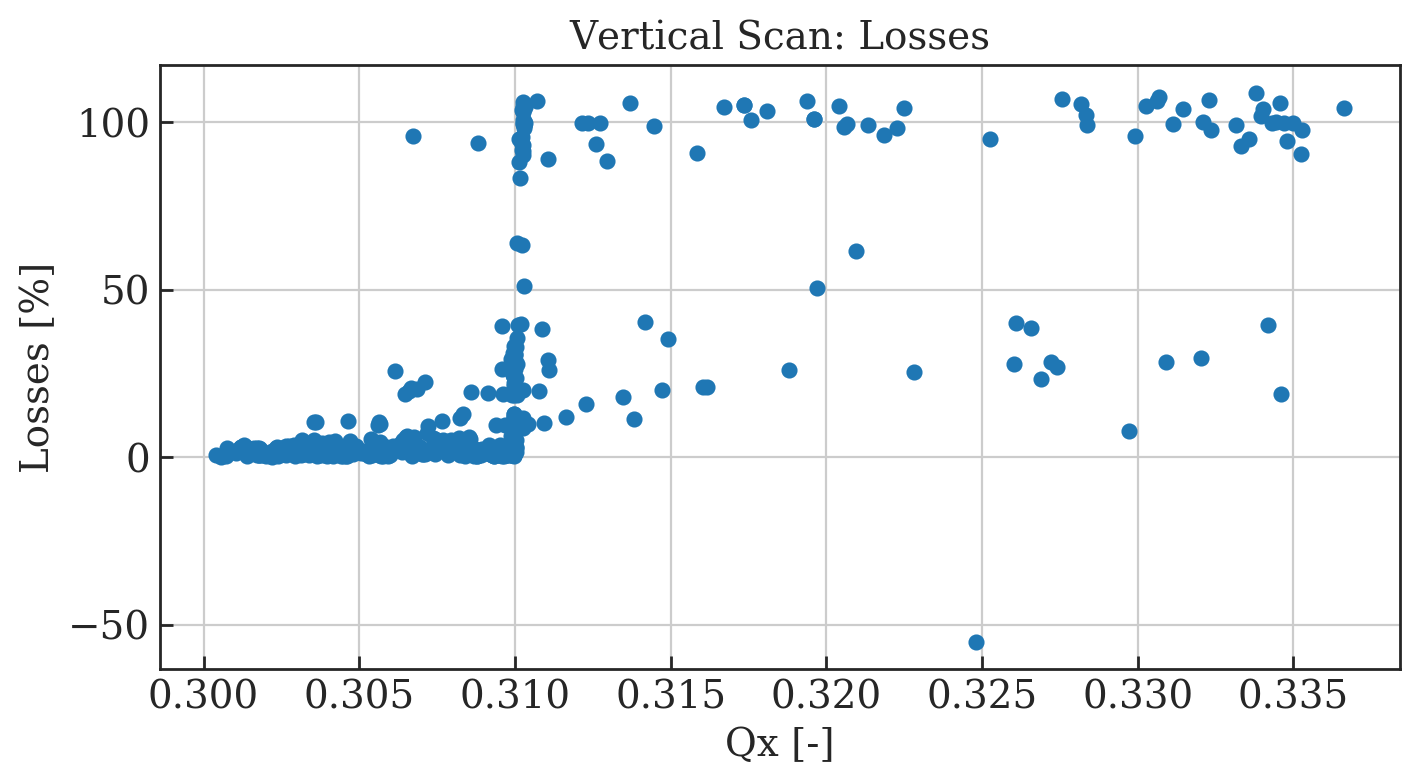

In [81]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_mergetest['Qx'],df_mergetest['losses'],'o')
plt.xlabel('Qx [-]')
plt.ylabel('Losses [%]')
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_NaturalChroma_Losses_Qx.png')

# Vertical Timber

In [83]:
dfV=read_data(year=2018,date=24,month=10,hour=19,minutes=20,span=8,user='CPS%MD8',WS='85.V')
dfV=profiles(dfV,WS='85.V')
dfV

/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_

,PR.BWS.85.V_ROT:PROF_POSITION_IN,PR.BWS.85.V_ROT:PROF_DATA_IN,PR.BWS.85.V_ROT:ACQ_DELAY,PR.BCT.LT:SAMPLES,cycleStamp,profile V,position V,sig V,mu V,c V,A V
2018-10-24 19:22:07.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146567842088286, 0.146738468668234, 0.14605...",175.0,"[-0.15825, -0.14783, -0.15028, -0.13494, -0.12...",1.540409e+18,"[0.0017703904682246623, 0.0017703904682246452,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,0.039133
2018-10-24 19:22:51.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147080317962865, 0.146397413911865, 0.14708...",172.0,"[-0.17481, -0.16316, -0.15089, -0.1423, -0.111...",1.540409e+18,NaN,"[-25.0, -24.94994994994995, -24.8998998998999,...",0.705723,-32.151262,0.159369,10.037639
2018-10-24 19:23:34.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146567842088286, 0.146397413911865, 0.14673...",175.0,"[-0.24229, -0.22634, -0.20364, -0.1742, -0.147...",1.540409e+18,"[0.0017564240725551578, 0.0017659911544322948,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.013458,-3.487542,0.149776,0.043081
2018-10-24 19:24:17.500,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146397413911865, 0.146057151847065, 0.14639...",185.0,"[-0.23002, -0.2245, -0.21591, -0.1926, -0.1729...",1.540409e+18,"[-0.0014486813414912917, -0.001426136184805680...","[-25.0, -24.94994994994995, -24.8998998998999,...",5.001748,-7.374125,0.148904,0.131987
2018-10-24 19:25:00.700,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147080317962865, 0.147080317962865, 0.14811...",172.0,"[-0.17236, -0.16071, -0.15089, -0.13065, -0.11...",1.540409e+18,NaN,"[-25.0, -24.94994994994995, -24.8998998998999,...",0.712195,-31.692941,0.159214,9.719055
2018-10-24 19:25:43.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146909293882681, 0.146738468668234, 0.14690...",175.0,"[-0.20487, -0.18463, -0.17113, -0.15396, -0.13...",1.540409e+18,"[0.0014643667810307875, 0.0014789552083074261,...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.524736,-3.835642,0.148918,0.288109
2018-10-24 19:26:27.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.14622718390827, 0.146567842088286, 0.146227...",185.0,"[-0.24535, -0.23002, -0.21898, -0.18954, -0.16...",1.540409e+18,"[-0.006284965471204607, -0.006341116695794859,...","[-25.0, -24.94994994994995, -24.8998998998999,...",6.475167,-10.157743,0.163089,2.144385
2018-10-24 19:27:10.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147422963646755, 0.147080317962865, 0.14776...",172.0,"[-0.1558, -0.15089, -0.15028, -0.13801, -0.120...",1.540409e+18,NaN,"[-25.0, -24.94994994994995, -24.8998998998999,...",0.700487,-31.860791,0.163323,8.553966
2018-10-24 19:27:57.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146909293882681, 0.146567842088286, 0.14571...",175.0,"[-0.20487, -0.1926, -0.17849, -0.15641, -0.138...",1.540409e+18,"[0.0020032431571651117, 0.002021966551081979, ...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.608672,-4.014365,0.149875,0.511071
2018-10-24 19:28:52.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147594585714287, 0.146567842088286, 0.14622...",185.0,"[-0.09875, -0.09323, -0.08587, -0.08097, -0.06...",1.540409e+18,"[0.0003826826612056925, 0.0003728767371097993,...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.823486,-3.747714,0.147709,0.545876


In [84]:
dfV=dfV.dropna(axis=0,how='all',subset =['profile V'])
dfV=dfV.dropna(axis=0,how='all',subset =['sig V'])
dfV

,PR.BWS.85.V_ROT:PROF_POSITION_IN,PR.BWS.85.V_ROT:PROF_DATA_IN,PR.BWS.85.V_ROT:ACQ_DELAY,PR.BCT.LT:SAMPLES,cycleStamp,profile V,position V,sig V,mu V,c V,A V
2018-10-24 19:22:07.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146567842088286, 0.146738468668234, 0.14605...",175.0,"[-0.15825, -0.14783, -0.15028, -0.13494, -0.12...",1.540409e+18,"[0.0017703904682246623, 0.0017703904682246452,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,0.039133
2018-10-24 19:23:34.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146567842088286, 0.146397413911865, 0.14673...",175.0,"[-0.24229, -0.22634, -0.20364, -0.1742, -0.147...",1.540409e+18,"[0.0017564240725551578, 0.0017659911544322948,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.013458,-3.487542,0.149776,0.043081
2018-10-24 19:24:17.500,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146397413911865, 0.146057151847065, 0.14639...",185.0,"[-0.23002, -0.2245, -0.21591, -0.1926, -0.1729...",1.540409e+18,"[-0.0014486813414912917, -0.001426136184805680...","[-25.0, -24.94994994994995, -24.8998998998999,...",5.001748,-7.374125,0.148904,0.131987
2018-10-24 19:25:43.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146909293882681, 0.146738468668234, 0.14690...",175.0,"[-0.20487, -0.18463, -0.17113, -0.15396, -0.13...",1.540409e+18,"[0.0014643667810307875, 0.0014789552083074261,...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.524736,-3.835642,0.148918,0.288109
2018-10-24 19:26:27.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.14622718390827, 0.146567842088286, 0.146227...",185.0,"[-0.24535, -0.23002, -0.21898, -0.18954, -0.16...",1.540409e+18,"[-0.006284965471204607, -0.006341116695794859,...","[-25.0, -24.94994994994995, -24.8998998998999,...",6.475167,-10.157743,0.163089,2.144385
2018-10-24 19:27:57.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146909293882681, 0.146567842088286, 0.14571...",175.0,"[-0.20487, -0.1926, -0.17849, -0.15641, -0.138...",1.540409e+18,"[0.0020032431571651117, 0.002021966551081979, ...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.608672,-4.014365,0.149875,0.511071
2018-10-24 19:28:52.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147594585714287, 0.146567842088286, 0.14622...",185.0,"[-0.09875, -0.09323, -0.08587, -0.08097, -0.06...",1.540409e+18,"[0.0003826826612056925, 0.0003728767371097993,...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.823486,-3.747714,0.147709,0.545876
2018-10-24 19:30:42.700,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147080317962865, 0.147080317962865, 0.14708...",175.0,"[-0.17972, -0.17297, -0.16255, -0.14783, -0.13...",1.540409e+18,"[0.0007448374493770615, 0.0007448374493770615,...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.057438,-3.812992,0.148555,1.095063
2018-10-24 19:31:37.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.147422963646755, 0.147594585714287, 0.14742...",185.0,"[-0.12697, -0.11838, -0.11041, -0.09201, -0.07...",1.540409e+18,"[0.00045270784312659475, 0.0004492160979763227...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.221674,-4.156146,0.147322,1.124860
2018-10-24 19:33:28.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146397413911865, 0.146567842088286, 0.14708...",175.0,"[-0.12329, -0.11716, -0.10796, -0.09875, -0.09...",1.540410e+18,"[0.0008282224067753603, 0.0008065279366470698,...","[-25.0, -24.94994994994995, -24.8998998998999,...",4.588058,-3.734134,0.146922,1.860465


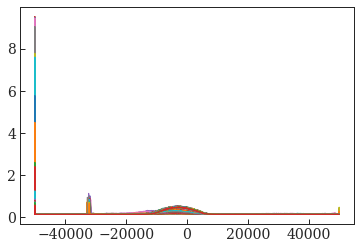

In [85]:
# Plot position vs profile
dfV.apply(lambda x: plt.plot( x['PR.BWS.85.V_ROT:PROF_POSITION_IN'],x['PR.BWS.85.V_ROT:PROF_DATA_IN']) ,axis=1);

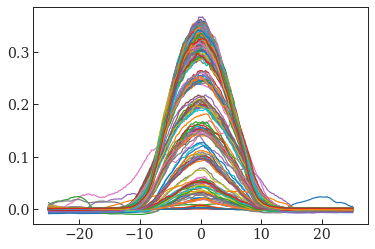

In [86]:
dfV.apply(lambda x: plt.plot( x['position V'],x['profile V']) , axis=1);

# Horizontal Timber - none recorded for this scan

## Merge

In [70]:
df_V=pnd.merge(df_intensity, dfV, left_index=True, right_index=True, how='outer')
df_V=df_V.dropna(how='all',subset =['cycleStamp_x'], axis=0)
df_V

,cycleStamp_x,matlabPLS_x,matlabFilePath_x,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,Qx,Qy,cycleStamp_y,matlabPLS_y,matlabFilePath_y,...,PR.BWS.85.V_ROT:PROF_DATA_IN,PR.BWS.85.V_ROT:ACQ_DELAY,PR.BCT.LT:SAMPLES,cycleStamp,profile V,position V,sig V,mu V,c V,A V
2018-10-24 19:22:07.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",0.319605,0.047874,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[0.146567842088286, 0.146738468668234, 0.14605...",175.0,"[-0.15825, -0.14783, -0.15028, -0.13494, -0.12...",1.540409e+18,"[0.0017703904682246623, 0.0017703904682246452,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,0.039133
2018-10-24 19:22:07.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",0.319605,0.047874,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[0.146567842088286, 0.146738468668234, 0.14605...",175.0,"[-0.15825, -0.14783, -0.15028, -0.13494, -0.12...",1.540409e+18,"[0.0017703904682246623, 0.0017703904682246452,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,0.039133
2018-10-24 19:22:51.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04737863670211139, nan, 0.04094432311483449...","[nan, 0.3105663235759711, nan, 0.3104163192336...",0.317362,0.054175,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-24 19:22:51.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04737863670211139, nan, 0.04094432311483449...","[nan, 0.3105663235759711, nan, 0.3104163192336...",0.317362,0.054175,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-24 19:23:34.300,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04044030959984465, nan, 0.04996536849943547...","[nan, 0.31042593103560623, nan, 0.310389703961...",0.310337,0.047860,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[0.146567842088286, 0.146397413911865, 0.14673...",175.0,"[-0.24229, -0.22634, -0.20364, -0.1742, -0.147...",1.540409e+18,"[0.0017564240725551578, 0.0017659911544322948,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.013458,-3.487542,0.149776,0.043081
2018-10-24 19:24:17.500,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04664160067391109, nan, 0.0648878841514922,...","[nan, 0.2968728698606682, nan, 0.3313028572717...",0.331443,0.045832,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[0.146397413911865, 0.146057151847065, 0.14639...",185.0,"[-0.23002, -0.2245, -0.21591, -0.1926, -0.1729...",1.540409e+18,"[-0.0014486813414912917, -0.001426136184805680...","[-25.0, -24.94994994994995, -24.8998998998999,...",5.001748,-7.374125,0.148904,0.131987
2018-10-24 19:25:00.700,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.0571496105118786, nan, 0.05288216912337934,...","[nan, 0.34399753790672566, nan, 0.328322764166...",0.321347,0.046086,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-24 19:25:43.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.042346359551280285, nan, 0.0398693342260222...","[nan, 0.30996969410456293, nan, 0.310411241749...",0.312361,0.053079,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[0.146909293882681, 0.146738468668234, 0.14690...",175.0,"[-0.20487, -0.18463, -0.17113, -

In [73]:
df_V=emittance_df(df_V,WS='85.V')
#PR.BWS.85.V_ROT:PROF_DATA_IN
df_V=df_V.dropna(axis=0,how='all',subset =['Qy'])
df_V=df_V.dropna(axis=0,how='all',subset =['sig V'])

df_V

,cycleStamp_x,matlabPLS_x,matlabFilePath_x,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,Qx,Qy,cycleStamp_y,matlabPLS_y,matlabFilePath_y,...,position V,sig V,mu V,c V,A V,emittance V,emittance H,betx,bety,dx
2018-10-24 19:22:07.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",0.319605,0.047874,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,0.039133,0.872490,NaN,23.069050,11.145160,2.997218
2018-10-24 19:22:07.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",0.319605,0.047874,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,0.039133,0.872490,NaN,23.069050,11.145160,2.997218
2018-10-24 19:23:34.300,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04044030959984465, nan, 0.04996536849943547...","[nan, 0.31042593103560623, nan, 0.310389703961...",0.310337,0.047860,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",2.013458,-3.487542,0.149776,0.043081,0.821876,NaN,23.069050,11.145160,2.997218
2018-10-24 19:24:17.500,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04664160067391109, nan, 0.0648878841514922,...","[nan, 0.2968728698606682, nan, 0.3313028572717...",0.331443,0.045832,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",5.001748,-7.374125,0.148904,0.131987,5.071827,NaN,23.069050,11.145160,2.997218
2018-10-24 19:25:43.900,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.042346359551280285, nan, 0.0398693342260222...","[nan, 0.30996969410456293, nan, 0.310411241749...",0.312361,0.053079,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",3.524736,-3.835642,0.148918,0.288109,2.518685,NaN,23.069050,11.145160,2.997218
2018-10-24 19:26:27.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04256077370422034, nan, 0.04488534621815969...","[nan, 0.31036935206023686, nan, 0.310342876369...",0.310312,0.043251,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",6.475167,-10.157743,0.163089,2.144385,8.500076,NaN,23.069050,11.145160,2.997218
2018-10-24 19:27:57.100,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.03976755758964533, nan, 0.05044438612629375...","[nan, 0.3101273614508164, nan, 0.3100795562762...",0.310080,0.049948,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",3.608672,-4.014365,0.149875,0.511071,2.640070,NaN,23.069050,11.145160,2.997218
2018-10-24 19:28:52.300,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.0671291765453128, nan, 0.04651366819331926,...","[nan, 0.31022731103569934, nan, 0.310264699425...",0.310243,0.043579,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,...,"[-25.0, -24.94994994994995, -24.8998998998999,...",3.823486,-3.747714,0.147709,0.545876,2.963737,NaN,23.069050,11.145160,2.997218
2018-10-24 19:30:42.700,1.540410e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[0.04182002781596029, nan, 0.04240801089990391...","[nan, 0.30544131939967906, nan, 0.331519554822...",0.330921,0.042688,1.540410e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224

In [74]:
def second_moment_2(values, weights, sig, n_sigmas=6.):
    a=np.where((values<n_sigmas*sig) & (values>-n_sigmas*sig))[0]
    values=values[a]
    weights=weights[a]    
    weighted_average = np.average(values, weights=weights)
    second_moment = np.sqrt(np.average((values-weighted_average)**2, weights=weights))
    return (second_moment)

In [75]:
df_V['second_moment V']=df_V.apply(lambda x: second_moment_2(x['position V'], x['profile V'], x['sig V'], n_sigmas=6.), axis=1);

/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt


In [76]:
def emittance_df(ndf,WS='85.V',myFiles=None,beta=0.91444281513833,gamma=2.4708737618826,dp=1e-3):
    df=ndf.copy()
    a=df.columns
    if 'emittance V' not in a:
        df['emittance V']=np.nan
    if 'emittance H' not in a:
        df['emittance H']=np.nan
    if 'sig V' not in a:
        df=profiles(df,WS=WS)
    if 'sig H' not in a:
        df=profiles(df,WS=WS)
    span=span_range(df,myFiles=myFiles)
    if WS[-1]=='V':
        if 'bety' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance V']=beta*gamma*(df['sig V'].iloc[i]**2)/df['bety'].iloc[i]
    else:
        if 'betx' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance H']=beta*gamma*(df['sig H'].iloc[i]**2-(df['dx'].iloc[i]*1000)**2*dp**2)/df['betx'].iloc[i]
    return df


Text(0,0.5,'Emittance y [mm mrad]')

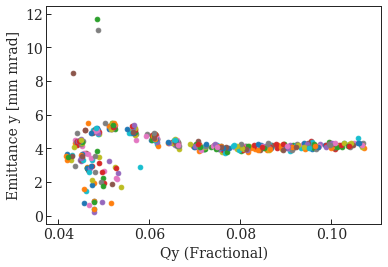

In [77]:
df_V.apply(lambda x: plt.scatter( x['Qy'], x['emittance V']) ,axis=1);
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance y [mm mrad]')

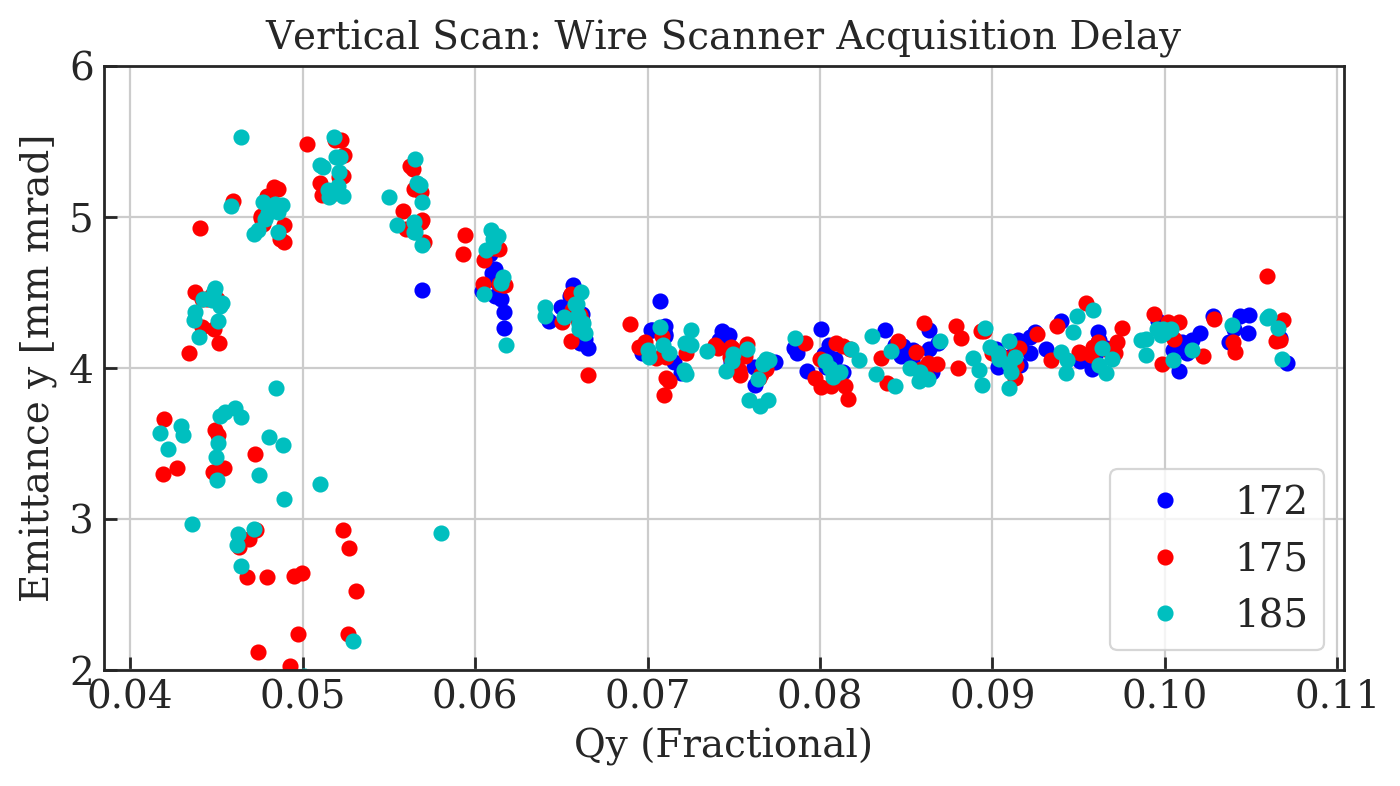

In [84]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_V['emittance V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_V['emittance V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_V['emittance V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Emittance y [mm mrad]')
plt.ylim(2, 6)
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_WS_Delay_Emittance.png')

Text(0.5,1,'Vertical Scan: Wire Scanner Acquisition Delay')

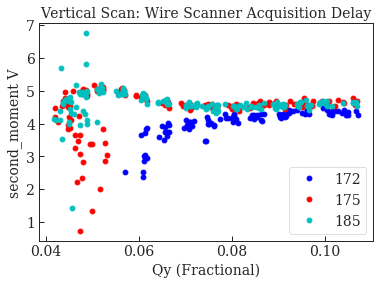

In [79]:
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_V['second_moment V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_V['second_moment V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_V['second_moment V'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('second_moment V')
plt.legend()
plt.title('Vertical Scan: Wire Scanner Acquisition Delay')

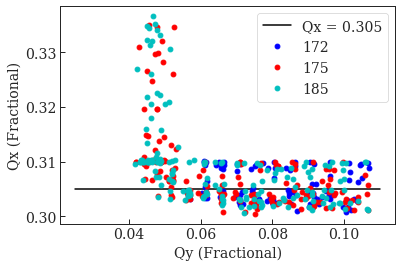

In [80]:
plt.plot([0.025, .11], [.305, .305], 'k-', lw=1.5, label='Qx = 0.305')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_V['Qx'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_V['Qx'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_V['Qy'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_V['Qx'][(df_V['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Qx (Fractional)')
plt.legend()
#plt.ylim(0.29, 0.32)

In [81]:
df_new=pnd.merge(dfV, df_intensity, left_index=True, right_index=True, how='outer')
df_new=df_new.dropna(axis=0,how='all',subset =['Qy'])
df_new=df_new.dropna(axis=0,how='all',subset =['sig V'])
df_new

,PR.BWS.85.V_ROT:PROF_POSITION_IN,PR.BWS.85.V_ROT:PROF_DATA_IN,PR.BWS.85.V_ROT:ACQ_DELAY,PR.BCT.LT:SAMPLES,cycleStamp,profile V,position V,sig V,mu V,c V,...,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,Qx,Qy,cycleStamp_y,matlabPLS_y,matlabFilePath_y,PR_BCT_ST.Samples.value.samples,losses,ratio
2018-10-24 19:22:07.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146567842088286, 0.146738468668234, 0.14605...",175.0,"[-0.15825, -0.14783, -0.15028, -0.13494, -0.12...",1.540409e+18,"[0.0017703904682246623, 0.0017703904682246452,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,...,"[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",0.319605,0.047874,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[-0.15825, -0.14783000000000002, -0.1502800000...",100.858302,-0.008583
2018-10-24 19:22:07.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146567842088286, 0.146738468668234, 0.14605...",175.0,"[-0.15825, -0.14783, -0.15028, -0.13494, -0.12...",1.540409e+18,"[0.0017703904682246623, 0.0017703904682246452,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.074531,-3.224151,0.149938,...,"[0.043652211519404585, nan, 0.0470124290875650...","[nan, 0.33018601371375267, nan, 0.342708177016...",0.319605,0.047874,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[-0.15825, -0.14783000000000002, -0.1502800000...",100.858302,-0.008583
2018-10-24 19:23:34.300,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146567842088286, 0.146397413911865, 0.14673...",175.0,"[-0.24229, -0.22634, -0.20364, -0.1742, -0.147...",1.540409e+18,"[0.0017564240725551578, 0.0017659911544322948,...","[-25.0, -24.94994994994995, -24.8998998998999,...",2.013458,-3.487542,0.149776,...,"[0.04044030959984465, nan, 0.04996536849943547...","[nan, 0.31042593103560623, nan, 0.310389703961...",0.310337,0.047860,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[-0.24229000000000003, -0.22634, -0.2036400000...",104.570482,-0.045705
2018-10-24 19:24:17.500,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146397413911865, 0.146057151847065, 0.14639...",185.0,"[-0.23002, -0.2245, -0.21591, -0.1926, -0.1729...",1.540409e+18,"[-0.0014486813414912917, -0.001426136184805680...","[-25.0, -24.94994994994995, -24.8998998998999,...",5.001748,-7.374125,0.148904,...,"[0.04664160067391109, nan, 0.0648878841514922,...","[nan, 0.2968728698606682, nan, 0.3313028572717...",0.331443,0.045832,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[-0.23002000000000003, -0.2245, -0.21591000000...",103.913050,-0.039131
2018-10-24 19:25:43.900,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.146909293882681, 0.146738468668234, 0.14690...",175.0,"[-0.20487, -0.18463, -0.17113, -0.15396, -0.13...",1.540409e+18,"[0.0014643667810307875, 0.0014789552083074261,...","[-25.0, -24.94994994994995, -24.8998998998999,...",3.524736,-3.835642,0.148918,...,"[0.042346359551280285, nan, 0.0398693342260222...","[nan, 0.30996969410456293, nan, 0.310411241749...",0.312361,0.053079,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[-0.20487000000000002, -0.18463000000000002, -...",99.582013,0.004180
2018-10-24 19:26:27.100,"[-49975.0, -49975.0, -49975.0, -49975.0, -4997...","[0.14622718390827, 0.146567842088286, 0.146227...",185.0,"[-0.24535, -0.23002, -0.21898, -0.18954, -0.16...",1.540409e+18,"[-0.006284965471204607, -0.006341116695794859,...","[-25.0, -24.94994994994995, -24.8998998998999,...",6.475167,-10.157743,0.163089,...,"[0.04256077370422034, nan, 0.04488534621815969...","[nan, 0.31036935206023686, nan, 0.310342876369...",0.310312,0.043251,1.540409e+18,CPS.USER.MD8,/eos/user/h/harafiqu/MD4224/2018.10.24_qpu_nat...,"[-0.24535, -0.23002000000000003, -0.21898, -0....",99.593009,0.004070
2018-10-24 19:27:5

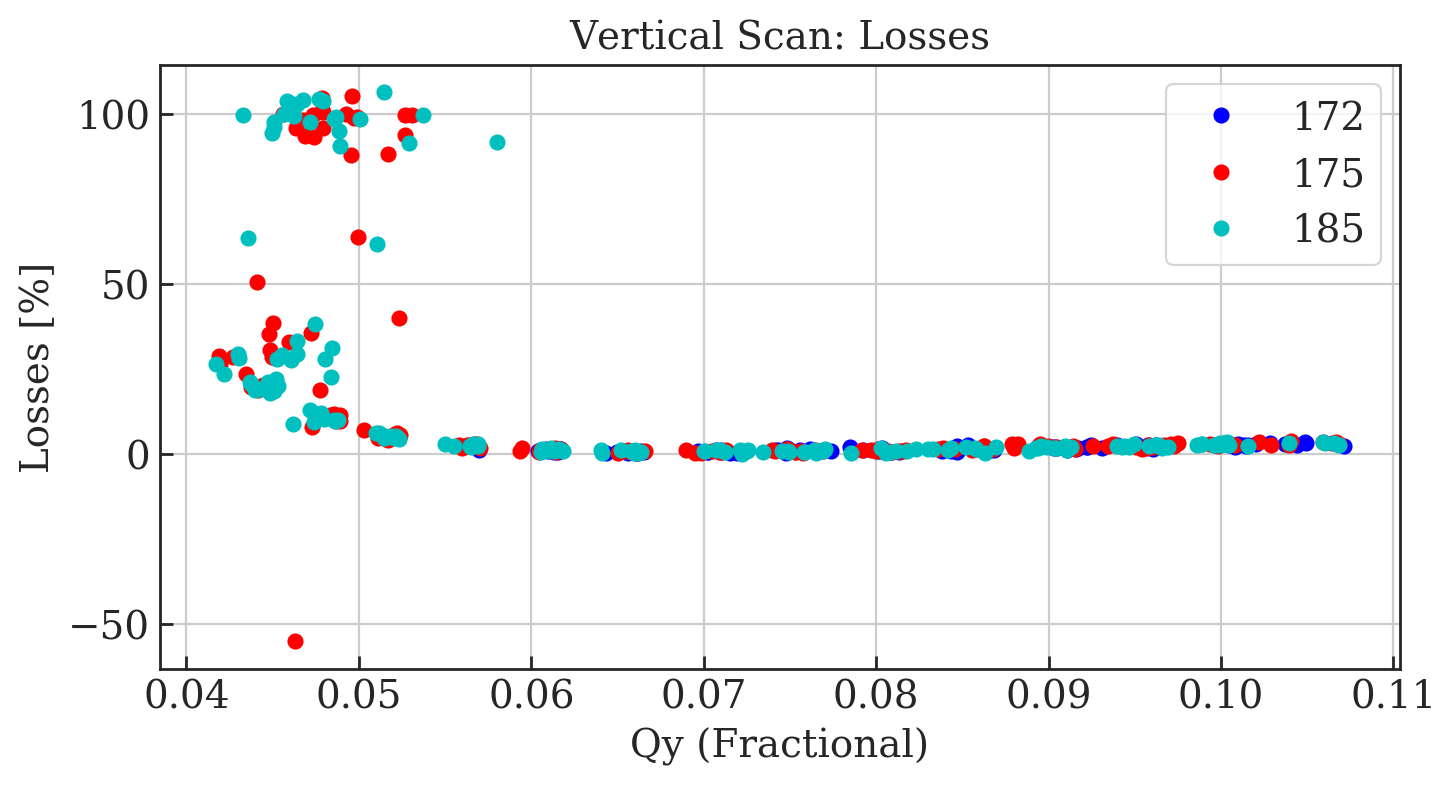

In [82]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_new['Qy'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==172)], df_new['losses'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(df_new['Qy'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==175)], df_new['losses'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(df_new['Qy'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==185)], df_new['losses'][(df_new['PR.BWS.85.V_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qy (Fractional)')
plt.ylabel('Losses [%]')
plt.legend()
plt.title('Vertical Scan: Losses')
plt.grid()
fig.savefig('MD4224_LowBrightness_Vertical_Losses_vs_WS_Acqusition.png')

# Tunespread calculation

In [1]:
%run /eos/user/h/harafiqu/SWAN_projects/PS/Tunespread_Calculator.ipynb

## Read TFS table names and assign to a dictionary

In [8]:
myTFSFiles=glob.glob('/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_Twiss/*.tfs')
myTomoEvalFiles=glob.glob('/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/*_eval.dat'')
#myTFSFiles
#myTomoFiles
myTomoEvalFiles

['/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001_deltap.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001_deltap_normampl.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001_eval.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001_eval_deltap.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001_eval_normampl.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001_normampl.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001_normampl_deltap.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_002.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_002_deltap.dat',
 '/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_

In [5]:
# This function takes a list of absolute paths to each file (use for example glob.glob('path_to_files/*.tfs'))
def create_dictionary_of_tfs_table_names(myTFSFiles):
    # We assume that we only vary tunes in one plane (vertical)
    TFSfiles = {}
    for item in myTFSFiles:
        absolute_filename = item                          # filepath
        filename = item.split('/')[-1]                    # filename
        integer = filename.split('p')[1].split('_')[1]    # integer Qy
        fractional = filename.split('p')[2].split('.')[0] # fractional Qy
        qy_str = (integer + '.' + fractional)             # concatenate strings
        qy_float = float(qy_str)                          # convert to float

        TFSfiles.update({qy_str : absolute_filename})
    return TFSfiles   

In [6]:
TFSfiles = create_dictionary_of_tfs_table_names(myTFSFiles)
#TFSfiles

In [7]:
# Iterate through tomo files
for item in myTomoEvalFiles:
    plot_longphasespace(item)

NameError: name 'myTomoFiles' is not defined

In [226]:
# Iterate through tomo files
for item in myTomoFiles:
    print item
    tomoData = extract_long_eval(item)
    print tomoData['time']
    # use cyclestamp to find correct tomo file
    if tomoData['time'] == row['cycleStamp']:
        print 'tomo file matched'

/eos/user/h/harafiqu/SWAN_projects/PS/MD4224_2018_10_22/tomo/2018-10-16_001.dat


ValueError: could not convert string to float: MD5=MD4224_BCMS48b_TFB_lowChroma


In [188]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

# Iterate over each row in the dataframe
for index, row in df_new.iterrows():
    
    #print row['Qy'], row['cycleStamp']
    
    integer_tune = 6
    fractional_tune = round_sig(row['Qy'],1)
    tune = integer_tune + fractional_tune
    
    # we want to use this twiss file:
    absolute_tfs_filename = TFSfiles[str(tune)]
    
    # Iterate through tomo files
    for item in myTomoFiles:
        tomoData = extract_long_eval(item)
        print tomoData['time']
        # use cyclestamp to find correct tomo file
        if tomoData['time'] == row['cycleStamp']:
            print 'tomo file matched'